# Building a model to detect fraudulent transactions. From EDA to Deploy.

# Model

# 2. Building Models
En esta sección se desarrollará un modelo matemático que aprenda a identificar si una transacción será fraudulenta o no. Dicho aprendizaje será con base en las propiedades de dicha transacción.

De la sección anterior, se encontró que la información está muy desbalanceada: $99.83%$ de transacciones no fraudulentas vs $0.17%$ de transacciones fraudulentas, por lo que se debe atacar este problema de manera especial.

Existen muchas técnicas para lidiar con este tipo de problemas.
- Seleccionar una métrica adecuada
- Hacer un re-sampleo del dataset.

___
## Métrica
Para seleccionar la métrica adecuada, recordemos que en clasificación binaria existe el concepto de la matriz de confusión, la cual muestra el número de:
- **Verdaderos positivos**: Transacciones fraudulentas clasificadas como fraudulentas.
- **Verdaderos negativos**: Transacciones no fraudulentas clasificadas como no fraudulentas.
- **Falsos positivos**: Transacciones no fraudulentas clasificadas como fraudulentas.
- **Falsos negativos**: Transacciones fraudulentas clasificadas como no fraudulentas.

Lo ideal sería que todas as transacciones fueran **verdaderos positivos** o **verdaderos positivos**, pero es algo que en la práctica es difícil de lograr. Para este caso de negocio específico, se debe tener especial cuidado con los falsos negativos, es decir, se desea que el número de **transacciones fraudulentas clasificadas como no fraudulentas** sea lo más bajo posible.

Por lo tanto, cuando se está entrenando un modelo de este estilo, es común hacer uso de dos métricas para evaluar el desempeño del modelo: *precision* y *recall*. Las fórmulas de dichas métricas están representadas por:

  - $$precision = \frac{VP}{VP + FP} $$
  - $$recall = \frac{VP}{VP + FN} $$

La **precision** es una medida de qué tan preciso es el modelo en detectar transacciones fraudulentas. El **recall** es la cantidad de transacciones fraudulentas que el modelo es capaz de detectar.

Finalmente, existe una métrica que relaciona estas dos: **F1 Score**. Esta métrica puede ser interpretada como un promedio armónico entre la *precision* y el *recall*. Su mejor valor se alcanza en $1$ y su peor valor en $0$. La contribución relativa de la precision y el recall en el score F1 es igual. La fórmula de dicha métrica es:

$$F1 = 2 \frac{precision * recall}{precion + recall}$$

Esta métrica e sla que se usará para el diseño del modelo.

___
## Re-sampleo
Comúnmente en problemas desbalanceados se utilizan dos técnicas para samplear las clases: sobre-sampleo y sub-sampleo.

1. **Sub-sampleo** de la clase mayoritaia. Consiste en eliminar ejemplos (transacciones) de la clase que más presencia tiene en los datos. En este caso, transacciones no fraudulentas.
2. **Sobre-sampleo** de la clase minoritara. Consiste en agregar ejemplos (transacciones) de la clase que menos presencia tiene en los datos. En este caso, transacciones fraudulentas.
3. Una combinación de las dos anteriores.

Para la técnica de sobre-sampleo, hay dos enfoques principales:

- Repetir muestras de la clase minoritaria.
- Usar la técnica de crear ejemplos sintéticos de la clase minoritaria **SMOTE** (por sus siglas en inglés: *Synthetic Minority Over-sampling Technique*. Dicha técnica se presenta en el siguiente procedimiento:
        - Se toma una muestra de la clase minoritaria.
        - Para las observaciones en esta muestra, se identificará a los $k$ vecinos más cercanos.
        - Se tomará uno de estos vecinos y se identificará el vector entre el punto de interés y su vecino.
        - Se multiplica dicho vector por un número random entre $0$ y $1$.
        - Se le suma dicho vector al punto de interés y así se obtiene el nuevo punto sintético.

En pocas palabras, este algoritmo (SMOTE) es similar a mover ligeramente un punto en dirección de su vecino. Esto asegura que se crean datos sintéticos que no son duplicados de los datos reales, pero que son ligeramente diferentes de los puntos originales.

Para el desarrollo del modelo se tomará una combinación del sub-sampleo con el sobre-sampleo usando la técnica SMOTE.

___
# Enfoque para el desarrollo del modelo
Para desarrollar el modelo (entrenar, evaluar, ree-entrenar y selección) se realizaran los siguientes pasos:
- Se dividirá los datos **ORGINALES** en conjunto de entrenamiento y validación. Esta división se hará de manera estratificada debido al imbalanceo existente. Se tomará un $70%$ de los datos para entrenamiento y un $30%$ de los datos para validación.
- Se realizará un escalado a todo el conjunto de datos.
- Se tomarán el conjunto de entrenamiento (el cuál estará imbalanceado) y se le aplicará la técnica de sampleo seleccionada y se dividirá dicho conjunto en dos subconjutos:un nuevo conjunto de entrenamiento y uno de testeo. Se realizará un proceso de cross-validation para el entrenamiento de diferentes modelos. Es importante especificar que la técnica de sampleo se debe hacer dentro del proceso de cross-validation, no antes.
- Se revisará la métrica seleccionada para evaluar el desempeño de los modelos y escoger el mejor.
- Se realizará un grid-Search para escoger los mejores hyper-parámetros basados en la métrica seeleccionada.
- Se seleccionará el mejor modelo con sus respectivos parámetros.
- Se evaluará los datos del punto uno (conjunto de validación, los cuáles no han sido vistos ni por el modelo, ni por el método de sampleo) para validar el desempeño final del modelo.

___
Para el entrenamiento del modelo, se realizará una división de los datos de manera estratificada. Se tomarán $70%$ de los datos para entrenamiento y $30%$ para validación.

Adicional, se realizará un escalado de los datos. Este escalado es necesario en muchos de los algoritmos utilizados para entrenar modelos en machine learning. El escalado se ajusta y transforma respecto a los datos de entrenamiento. Para los datos de testeo y validación solamente se realiza la transformación. Esto con el fin de no introducir bias de los datos de testeo y validación en el entrenamiento del modelo.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pandas as pd

# Importing the data
df_final = pd.read_parquet("../data/df_final.parquet.gzip")

# Define the features of the data and the output class.
X = df_final.drop(columns=['is_fraud'])
y = df_final['is_fraud']

# Splitting the set in train set and validation set in a stratified way.
X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.3, stratify=y)

#Splittin the set in train and test set in a stratified way
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# RobustScaler to scalate the features in the data.
scaler = RobustScaler()

# Fit and transform of the data w.r.t the train data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)

# Transform the test data with the scaler fitted previously
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Transform the validation data with the scaler fitted previously
X_validation = pd.DataFrame(scaler.transform(X_validation), columns=X.columns)

___
Para el proceso de sampleo, se usará la librería `imbalanced-learn` la cuál se basa en la librería `scikit-learn` y proporciona herramientas para problemas de clasificación imbalanceada. Dicha librería trae los métodos para realizar el sampleo.

Actualmente el imbalanceo está del orden de $1:100$ (un ejemplo de la clase minoritaria por cada 100 ejemplos de la clase mayoritaria, esto se ve en el porcentaje de imbalanceo visto anteriormente).

La estrategia para lidiar con esto será la siguiente:
- Se aplicará un sobre-sampleo con el algoritmo SMOTE en donde se desea llegar a una relación $1:10$ (una transaccion fraudulenta por cada diez no fraudulentas).
- Después se aplicará un sub-sampleo aleatorio. Con esto se eliminarán transacciones no fraudulentas hasta llegar a una relación de $1:2$ (una transaccion fraudulenta por cada dos no fraudulentas).

Dicha estrategia se agregará a Pipeline de `scikit-learn` para ser usado posteriormente.

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Sampling techniques. over-sampling and under-sampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

___
Ahora se creará una función generalizada para evaluar los modelos.
Esta función recibe como argumento los siguientes parámetros:
- `X_train`: Conjunto de características de entrenamiento
- `y_train`: Conjunto de salidas de entrenamiento
- `X_test`: Conjunto de características de testeo
- `y_test`: Conjunto de salidas de testeo
- `model`: modelo a entrenar
- `param_grid`: Conjunto de parámetros a evaluar en el modelo.

La función hará una división estratificada de los datos de entrenamiento. Después verificará el conjunto de parámetros cuál es la combinación que se comporta mejor respecto a la métrica seleccionada (`f1_score`). Finalmente evaluará el mejor modelo en el conjunto de testeo. Esta función regresará un diccionario con el mejor score de entrenamiento, el score de testeo y los mejores parámetros con los que desempeñó el entrenamiento.

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def evaluate_model(X_train, y_train, X_test, y_test, model, param_grid):
    """
    Function to evaluate a specific model and find the best set of parameters for the F1 score. The evaluation of the model is in the train set, and it's used a StratifiedKFold divison, and a GridSearchCV approach.
    :param X_train: Features train set
    :param y_train: Class train set
    :param X_test: Features test set
    :param y_test: Class test set
    :param model: Model to evaluate
    :param param_grid: Dictionary with the set of parameters to evaluate
    :return: A dictionary with the best score of the model, the test score and the set of the best parameters.
    """
    # Creating a scikit-lean pipeline with the sampling techniques and the model to train
    pipeline_model =  Pipeline(steps=[('over', over), ('under', under), ('model', model)])

    # Define the number of fold to divide the test set
    cv = StratifiedKFold(n_splits=10)

    # Grid Search object to find the best combination fo parameter. Use Cross-Validation approach to train the model. A f1 score is used to evaluate the performance. n_jobs=-1 indicate that all processor of the local machine are used to this process.
    grid_search = GridSearchCV(estimator=pipeline_model,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=cv,
                               n_jobs=-1)

    # Fit the grid search object to  the train set.
    grid_search.fit(X_train, y_train)

    # Save the best score (F1 score) of the Grid Search process.
    cv_score = grid_search.best_score_

    # Save the best parameters of the Grid Search process.
    cv_params = grid_search.best_params_

    # Save the test score (F1 score)
    test_score = grid_search.score(X_test, y_test)

    return {'model': grid_search,
            'cv_score': cv_score,
            'test_score': test_score,
            'best_params': cv_params
            }

___
Una vez definida la función, se procederá a guardar en un listado los modelos y conjuntos de parámetros para ejecutar dicha función y encontrar cuál es el mejor modelo.

In [13]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Object model and parameters for a Logistic Regressor.
lr_clf = LogisticRegression()
lr_params = {}

# Set with the Logistic information
lr_set = ('Logistic Regression', lr_params, lr_clf)

# Object model and parameters for a Random Forest Classifier.
rf_clf = RandomForestClassifier()
rf_params = {'model__bootstrap': [True],
             'model__max_depth': [10, 20, 30],
             'model__min_samples_leaf': [2, 4],
             # 'model__n_estimators': [200, 1400]
             }

# Set with the Random Forest information
rf_set = ('Random Forest', rf_params, rf_clf)


# Object model and parameters for a XGBoost Classifier.
xgb_clf = xgb.XGBClassifier()
xgb_params = {'model__scale_pos_weight': [None, 2],
              'model__max_depth': [4, 5, 6, 7],
              'model__gamma': [0, 0.5, 1, 1.5, 2]
              }

# Set with the Random Forest information
xgb_set = ('XGBoost', xgb_params, xgb_clf)

# List with the info of the above Classifiers
list_clf = [lr_set, rf_set, xgb_set]

In [14]:
# Dict to save the result of each model
evaluation_dict = {}

# For cycle to iter the list with the info about each classifier
for clf_set in list_clf:

    # Unpack the specific model name
    model_name = clf_set[0]

    # Unpack the specific dict of parameters
    param_grid = clf_set[1]

    # Unpack the specific object model
    model = clf_set[2]

    # Save in a key of the evaluation_dict the result of each model. The evaluate_model function is used in this step.
    evaluation_dict[model_name] =  evaluate_model(X_train, y_train, X_test, y_test, model=model, param_grid=param_grid)

___
Se procederá a evaluar los modelos y sus respectivos parámetros y encontrar el mejor conjunto de parámetros de cada uno que maximiza la métrica escogida.

In [15]:
for model, dict_ in evaluation_dict.items():
    print(f"El score de entrenamiento para el clasificador {model} es {dict_['cv_score']} \n "
          f"El score de testeo para el clasificador {model} es {dict_['test_score']}")

El score de entrenamiento para el clasificador Logistic Regression es 0.18009297542749536 
 El score de testeo para el clasificador Logistic Regression es 0.17745302713987474
El score de entrenamiento para el clasificador Random Forest es 0.8091127637903526 
 El score de testeo para el clasificador Random Forest es 0.7766990291262135
El score de entrenamiento para el clasificador XGBoost es 0.7153654253341153 
 El score de testeo para el clasificador XGBoost es 0.6919831223628692


___
De la información anterior se puede observar que el regresor logístico tiene un pobre desempeño, mientras que los árboles de decisión tiene un mejor comportamiento. Por lo menos respecto al conjunto de entrenmaiento y testeo.

___
Ahora se va a definir los modelos con los mejores parámetros encontrados en el proceso anterior.

In [16]:
for model, dict_ in evaluation_dict.items():
    print(f"El mejor conjunto de parámetros para el {model} son {dict_['best_params']}")

El mejor conjunto de parámetros para el Logistic Regression son {}
El mejor conjunto de parámetros para el Random Forest son {'model__bootstrap': True, 'model__max_depth': 30, 'model__min_samples_leaf': 2}
El mejor conjunto de parámetros para el XGBoost son {'model__gamma': 0, 'model__max_depth': 7, 'model__scale_pos_weight': None}


In [17]:
# Classifier object with the best set of parameters for Logistic Regression.
lr_clf = LogisticRegression(solver='liblinear', C=0.001, penalty='l1')
# Fitting the object to the train test.
lr_clf.fit(X_train, y_train)

# Classifier object with the best set of parameters for Random Forest.
rf_clf = RandomForestClassifier(bootstrap=True, max_depth=30, min_samples_leaf=2)
# Fitting the object to the train test.
rf_clf.fit(X_train, y_train)

# Classifier object with the best set of parameters for XGBoost.
xgb_clf = xgb.XGBClassifier(gamma=0, max_depth=7)
# Fitting the object to the train test.
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

___
Una vez definido los mejores parámetros para cada modelo, se procederá realizar las predicciones pertinenes sobre el conjunto de testeo y de validación para cada modelo.

In [18]:
# Test and validation set prediction for the Logistic Regression Classifier
y_test_lr_predict = lr_clf.predict(X_test)
y_validation_lr_predict = lr_clf.predict(X_validation)

# Test and validation set prediction for the Random Forest Classifier
y_test_rf_predict = rf_clf.predict(X_test)
y_validation_rf_predict = rf_clf.predict(X_validation)

# Test and validation set prediction for the XGBoost Classifier
y_test_xgb_predict = xgb_clf.predict(X_test)
y_validation_xgb_predict = xgb_clf.predict(X_validation)

___
Usando las predicciones de cada uno de los modelos, se procederá a visualizar la matriz de confusión, la cuál dará información sobre la validez de las predicciones. Para ello se definirá una función que grafique dicha matriz con base en las predicciones y los valores reales.

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_matrix(y_test, y_pred):
    """
    Function to plot the confusion matrix.
    :param y_test: Set of the real values of the classes
    :param y_pred: Set of the predicted values of the clasess.
    :return: A matrix graph with the informaticon about the number of True Positive, True Negative, False Positive and False Negative.
    """
    # Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Set the font size in seaborn graphs
    sns.set(font_scale=2)

    plt.figure(figsize=(8,8))
    ax = sns.heatmap(cf_matrix, annot=True, fmt=".0f", cmap='Blues')

    # Set a tittle, x-label and y-label for the plot
    ax.set_title('Matriz de confusión (¿Es Fraudulenta la Transacción?)\n\n');
    ax.set_xlabel('Valores predecidos por el modelo')
    ax.set_ylabel('Valores reales');

    # Set the ticket labels
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    # Show the plot of the Confusion Matrix.
    return plt.show()

___
### Matriz de confusión para el clasificador por `Regresión Logística`.

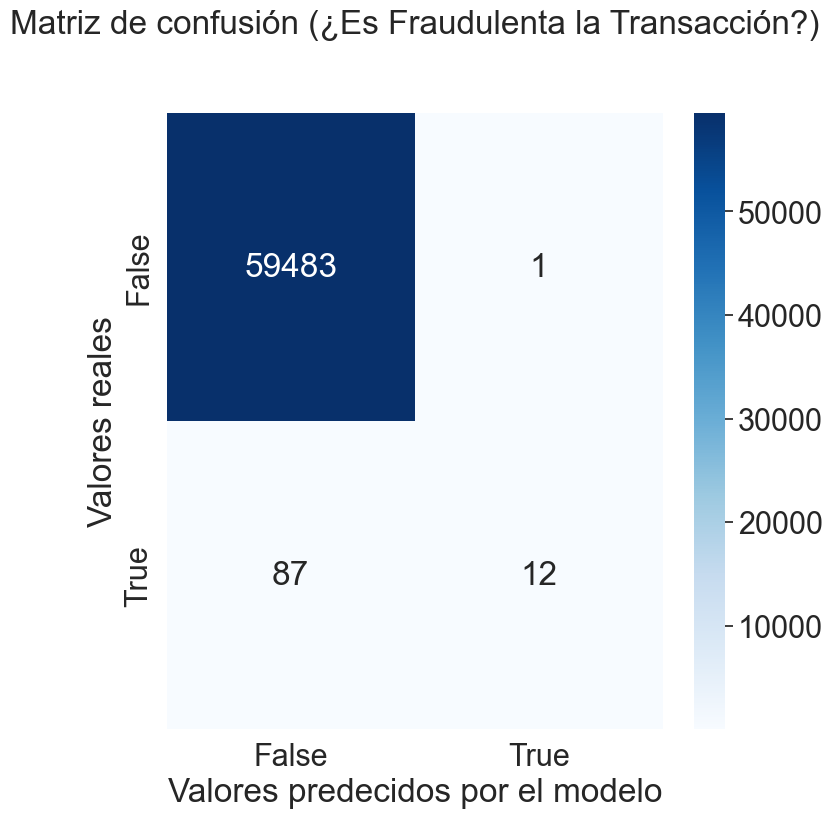

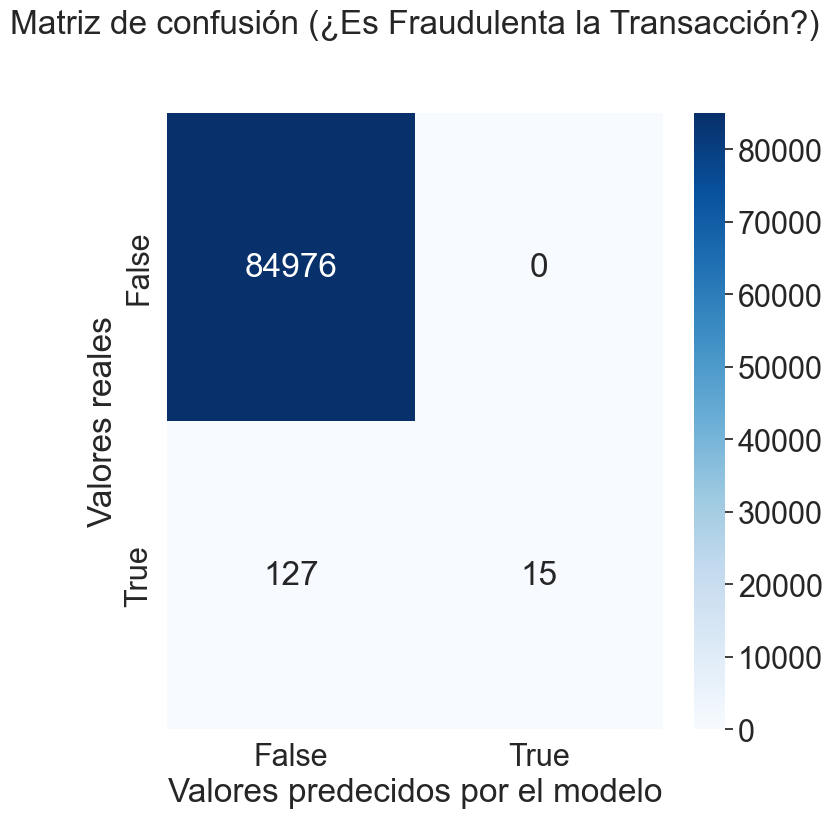

In [25]:
plot_conf_matrix(y_test, y_test_lr_predict)
plot_conf_matrix(y_validation, y_validation_lr_predict)

___
De las Figuras anteriores, se comprueba lo mostrado en las métricas de entrenamiento y testeo, y es que aunque el clasificador por regresión logística determina muy bien las transacciones no-fraudulentas, no sucede lo mismo con las no-fraudulentas.

___
### Matriz de confusión para el clasificador `Random Forest`.

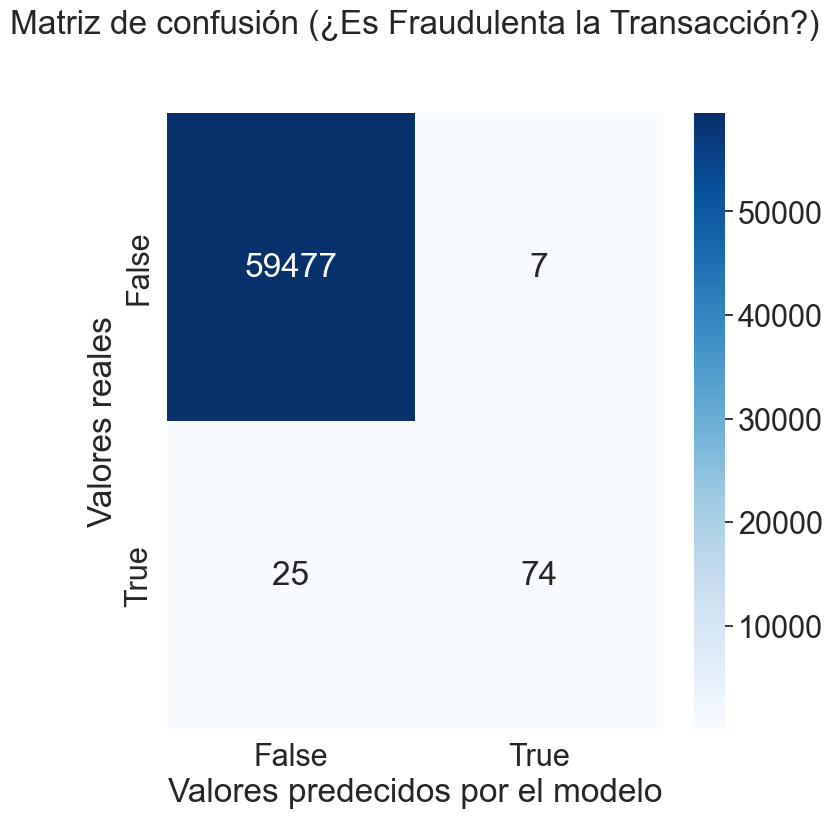

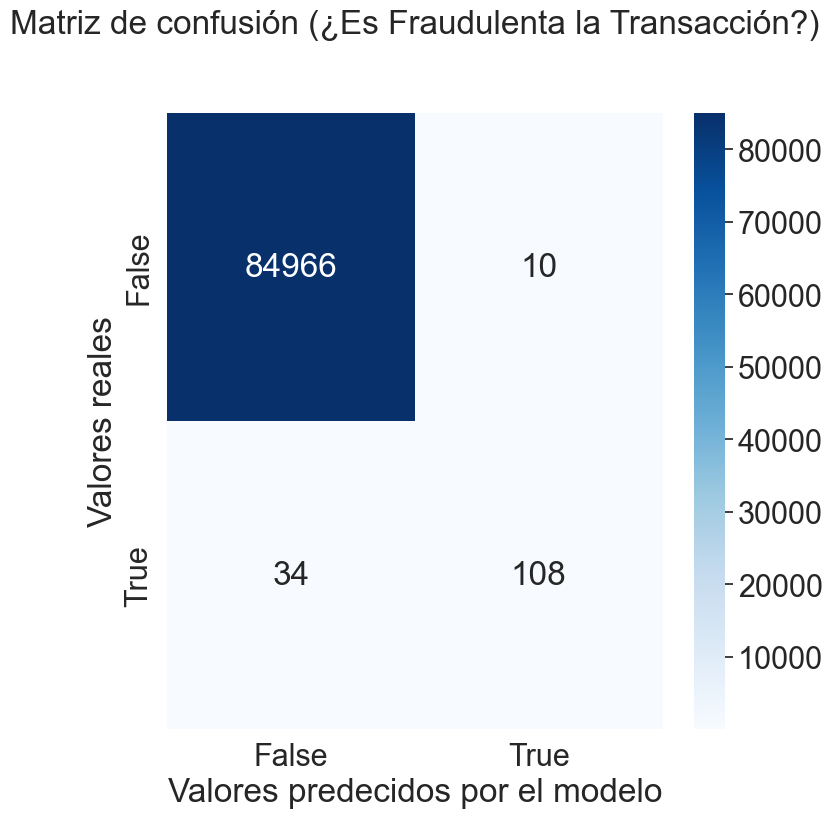

In [26]:
plot_conf_matrix(y_test, y_test_rf_predict)
plot_conf_matrix(y_validation, y_validation_rf_predict)

___
### Matriz de confusión para el clasificador `XGBoost`.

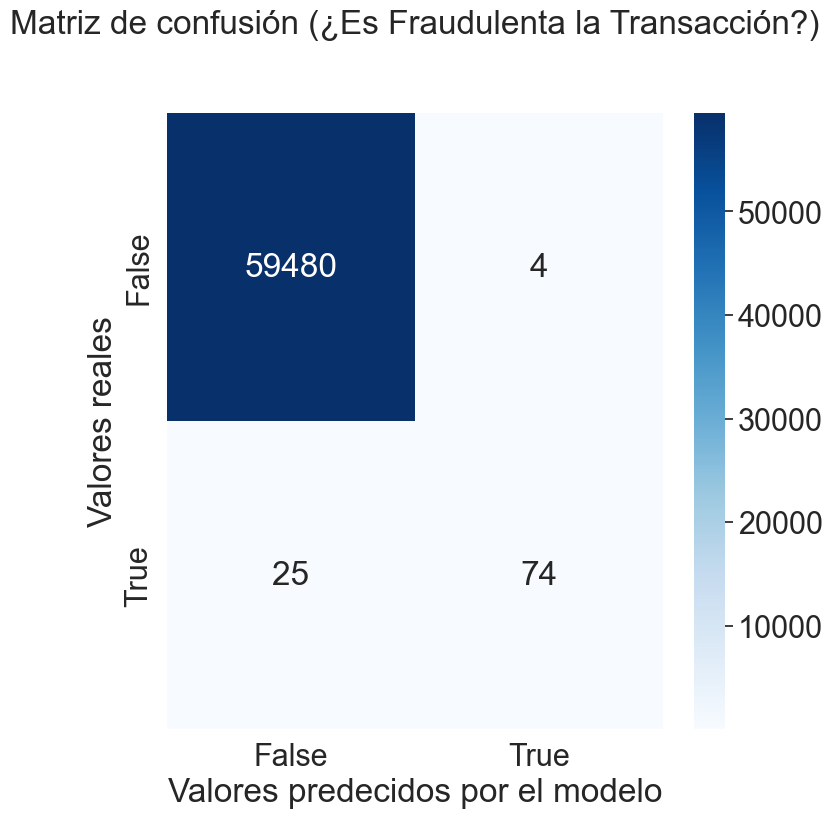

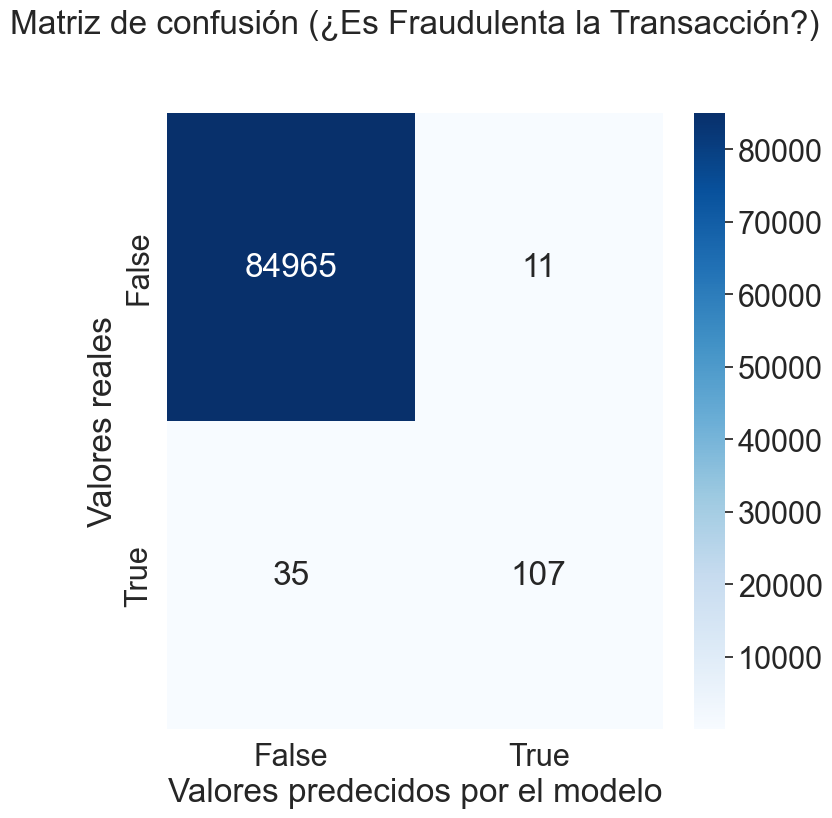

In [27]:
plot_conf_matrix(y_test, y_test_xgb_predict)
plot_conf_matrix(y_validation, y_validation_xgb_predict)

___
### Selección del modelo
Con base en el desempeño anterior, se decide seleccionar como modelo ganador al `Random Forest`, con el diferenciador respecto al `XGBoost` de que detectó menos Falsos Positivos.

___
Finalmente, se va a analizar la importancia de las características de cada uno de los modelos obtenidos.

Se definirá una función que grafique ficha importancia.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance_features(features_name, feature_importance):
    """
    Funtion to plot the feature importance in a specific model
    :param features_name: List with the name of each feature
    :param feature_importance: List with the value of the importance of each feature
    :return: A plot with the features sorted by importance.
    """

    # Define a dataFrame with the information
    df_features = pd.DataFrame({'Feature': features_name, 'Feature importance': feature_importance})
    # Sorting the DataFrame
    df_features.sort_values(by='Feature importance', ascending=False, inplace=True)

    # Set the font size in seaborn graphs
    sns.set(font_scale=1)

    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=df_features)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    return plt.show()

### Importancia de características para el clasificador `Random Forest`

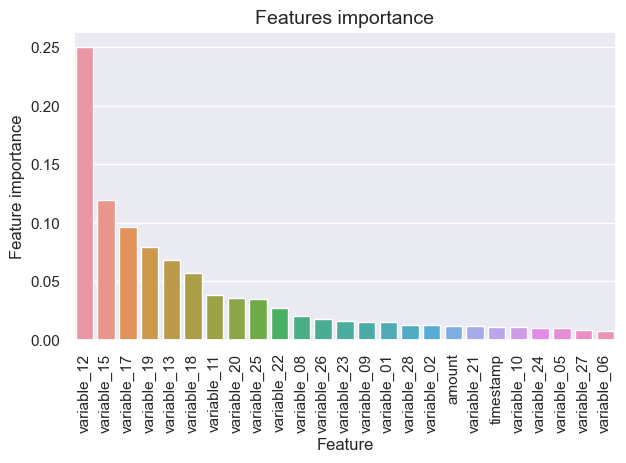

In [22]:
plot_importance_features(rf_clf.feature_names_in_, rf_clf.feature_importances_)

### Importancia de características para el clasificador `XGBoost`

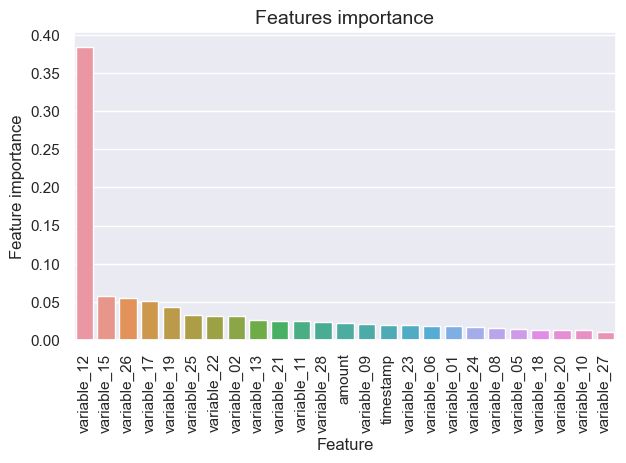

In [23]:
plot_importance_features(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)

___
Se obtiene las gráficas de importancia de las características de los modelos que mejor desempeño tuvieron en el conjunto de validación: `Random Forest` y `XGBoost`. De estas Figuras se puede observar que el top $4$ de características más relevantes coincide (en diferente orden):
- variable_12
- variable_17
- variable_15
- variable_19

Este hallazgo nos muestra la importancia que tienen dichas variables en el modelo de clasificación y que son determinantes a la hora de saber si una transacción será fraudulenta o no.

Adicionalmente, la baja importancia que tienen las variables de `timestamp` y `amount` en la decisión final de definir una transacción fraudulenta.

En la siguiente sección se hablará sobre dichas variables y la recomendación que se hace al respecto.

# Saving the selected model


In [28]:
import pickle

with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

with open('model_fraud.pickle', 'wb') as f:
    pickle.dump(rf_clf, f)

In [29]:
df_final.columns

Index(['variable_06', 'is_fraud', 'variable_02', 'variable_05', 'variable_01',
       'variable_23', 'variable_19', 'variable_10', 'amount', 'variable_22',
       'variable_28', 'timestamp', 'variable_11', 'variable_21', 'variable_13',
       'variable_17', 'variable_09', 'variable_25', 'variable_08',
       'variable_26', 'variable_24', 'variable_15', 'variable_18',
       'variable_27', 'variable_12', 'variable_20'],
      dtype='object')